# 👩‍🚀 Portability - DALL-E to Stable Diffusion img2img from Notebook to Inference Service

We've talked about using Stable Diffusion to generate a new version of the logo on our landing page every day. Stable diffusion alone hasn't been able to generate anything meaningful, but let's try creating seed images with DalleMini and then use Stable Diffusion img2img to refine them.

Based on: https://github.com/huggingface/diffusers/blob/main/README.md#image-to-image-text-guided-generation-with-stable-diffusion

In [ ]:
!pip install runhouse

In [2]:
import runhouse as rh
import torch
from PIL import Image
import random

### Login to Runhouse to load in secrets

In [ ]:
# You can add token=<your token> if you want to be able to run this without pasting into stdin
rh.login(download_secrets=True, download_config=True, interactive=True)

In [ ]:
# Only if you're using GCP and running inside Colab
!gcloud init
!gcloud auth application-default login
!cp -r /content/.config/* ~/.config/gcloud

In [ ]:
# Check that secrets are loaded in properly and at least one cloud is ready to use.
!sky check

### Running DALL-E
First, let's try generating some images using DALL-E.

In [ ]:
gpu = rh.cluster('rh-a10x')
gpu.up_if_not()

In [ ]:
def unclip_generate(prompt, model_id='kakaobrain/karlo-v1-alpha', num_images=1, **model_kwargs):
    import runhouse as rh
    from diffusers import UnCLIPPipeline
    import torch

    pipe = rh.get_pinned_object(model_id)
    # pin to memory if not already
    if pipe is None:
        pipe = UnCLIPPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to('cuda')
        rh.pin_to_memory(model_id, pipe)
    return pipe([prompt], num_images_per_prompt=num_images, **model_kwargs).images

# create Runhouse send function
generate_karlo_gpu = rh.send(fn=unclip_generate, 
                             hardware=gpu,
                             reqs=['local:./', 'torch --upgrade --extra-index-url https://download.pytorch.org/whl/cu116',
                                   'diffusers', 'transformers', 'accelerate'],
                             name='karlo_generate').save()

The first time we call this send, in the cell below, it will take ~8 minutes to download the model, which is pretty large. Subsequent calls will only take ~1 second per image (because we've pinned the model to GPU memory!).

INFO | 2023-02-07 20:51:57,014 | Running karlo_generate via gRPC
INFO | 2023-02-07 20:52:10,035 | Time to send message: 13.02 seconds


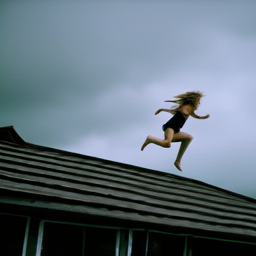

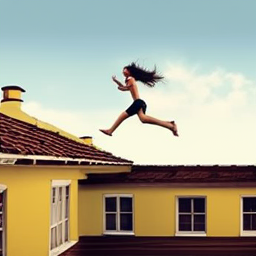

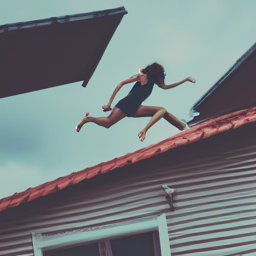

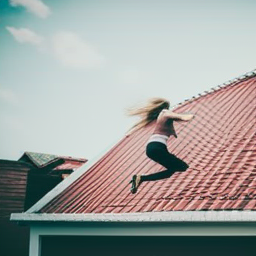

[None, None, None, None]

In [6]:
rh_prompt = 'A digital photo of a woman running on the roof of a house.'

rh_logo_dalle_images = generate_karlo_gpu(rh_prompt, num_images=4)
[display(image) for image in rh_logo_dalle_images]

### Stable Diffusion Img2Img
Now let's try feeding these into StableDiffusionImg2Img. 

First let's see if we have enough GPU memory to put it on our A10G/A100. If not, we can just put it on a V100 (on any provider, it doesn't matter).

In [7]:
gpu.run(['nvidia-smi'])
True

INFO | 2023-02-07 20:52:14,406 | Running command on rh-a10x-aws: nvidia-smi
Tue Feb  7 20:52:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10G         On   | 00000000:00:1E.0 Off |                    0 |
|  0%   29C    P0    56W / 300W |  13891MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
            

True

Looks like we're ok to put StableDiffusion (~5.2GB) on our A10G/A100.

In [ ]:
def sd_img2img_generate(prompt, base_images, num_images=1,
                        steps=50, strength=0.75, guidance_scale=7.5,
                        model_id="stabilityai/stable-diffusion-2-base"):
    import runhouse as rh
    from diffusers import StableDiffusionImg2ImgPipeline
    import torch
    
    pipe = rh.get_pinned_object(model_id + 'im2img')
    if pipe is None:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cuda.matmul.allow_fp16_reduced_precision_reduction = True
        pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id).to('cuda')
        rh.pin_to_memory(model_id + 'im2img', pipe)
    ret = []
    for image in base_images:
        ret = ret + pipe([prompt] * num_images, init_image=image.resize((512, 512)),
                         num_inference_steps=steps, strength=strength,
                         guidance_scale=guidance_scale).images
    return ret

sd_img2img_generate_gpu = rh.send(fn=sd_img2img_generate, hardware=gpu,
                                  reqs=['local:./', 'torch --upgrade --extra-index-url https://download.pytorch.org/whl/cu116',
                                   'diffusers', 'transformers', 'accelerate'],
                                  name='sd_img2img_generate').save()

This too will take ~3 minutes to run the first time to download the model, and after that should only take ~1 second per image.

INFO | 2023-02-07 20:56:06,499 | Running sd_img2img_generate via gRPC
INFO | 2023-02-07 20:57:26,072 | Time to send message: 79.57 seconds


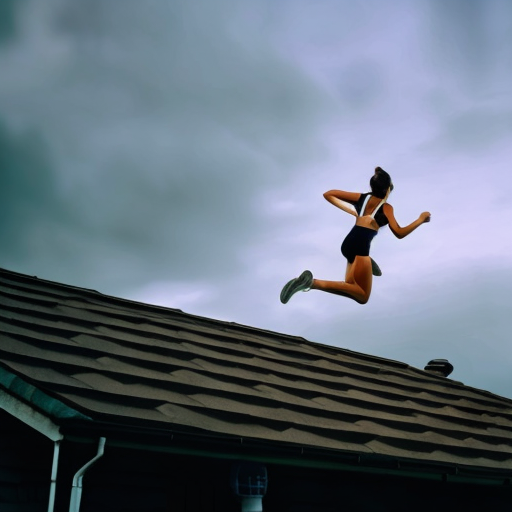

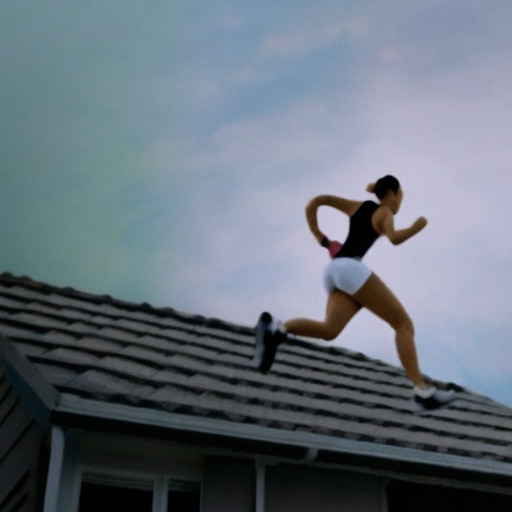

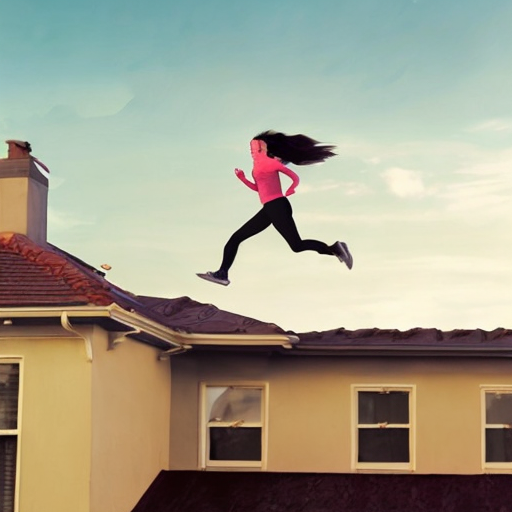

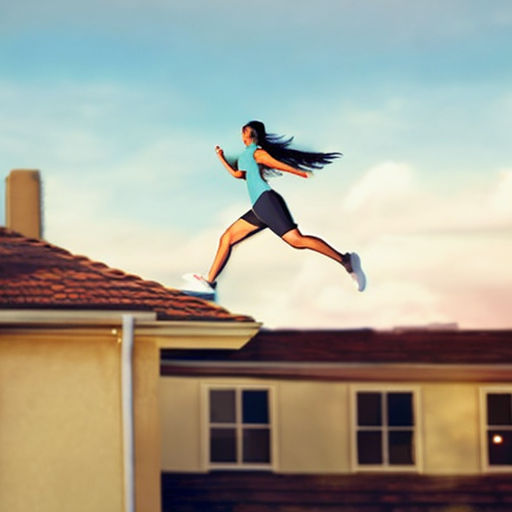

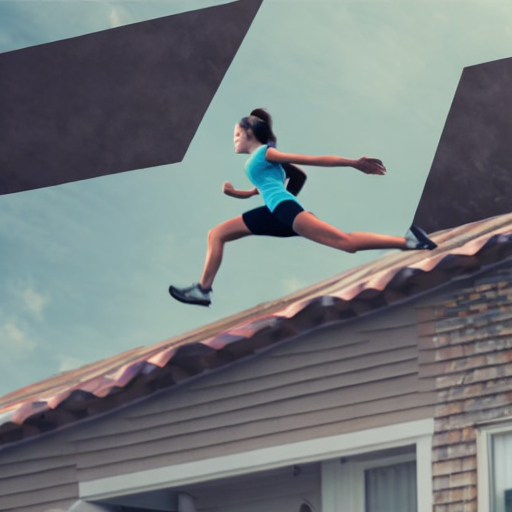

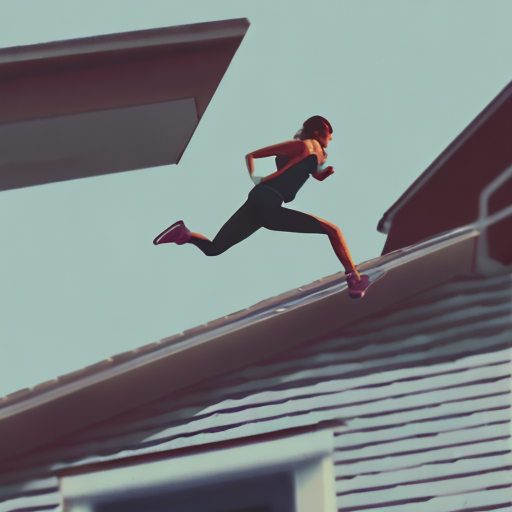

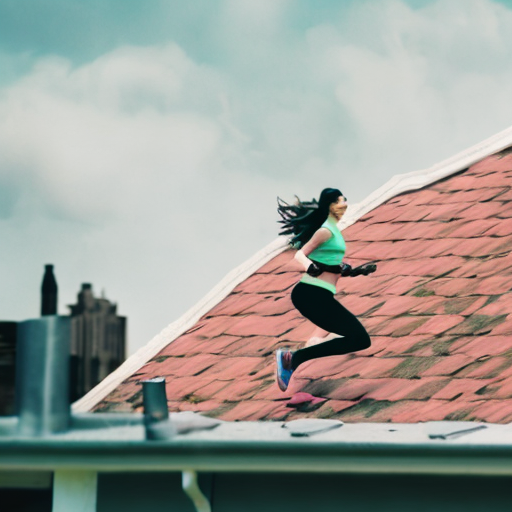

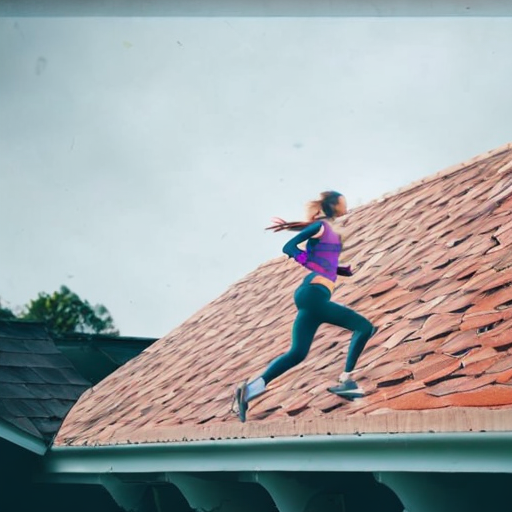

[None, None, None, None, None, None, None, None]

In [13]:
rh_logo_dalle2sd_images = sd_img2img_generate_gpu(rh_prompt, rh_logo_dalle_images, num_images=2,
                                                  strength=.75, guidance_scale=7.5, steps=25)

[display(image) for image in rh_logo_dalle2sd_images]

You can a,so upload your own photo here if you'd like to try the img2img service on it. Here, we are passing in a screenshot of the emoji woman running on a house. 

Saving Emoji.png to Emoji.png


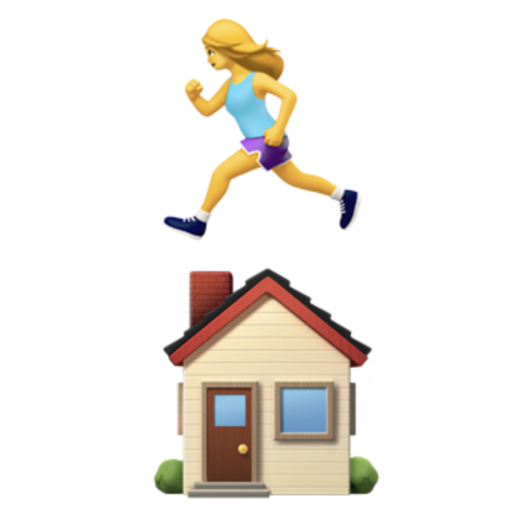

In [17]:
from google.colab import files
from PIL import Image
from io import BytesIO

uploaded_img_bytes = files.upload()
uploaded_img = Image.open(BytesIO(list(uploaded_img_bytes.values())[0])).convert('RGB')
uploaded_img.resize((512, 512))

INFO | 2023-02-07 21:05:10,323 | Running sd_img2img_generate via gRPC
INFO | 2023-02-07 21:05:25,383 | Time to send message: 15.06 seconds


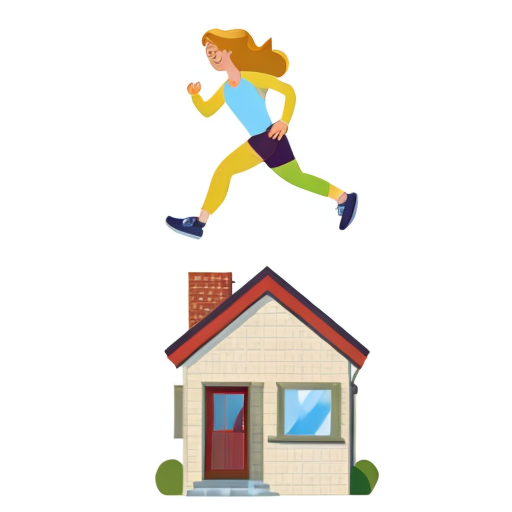

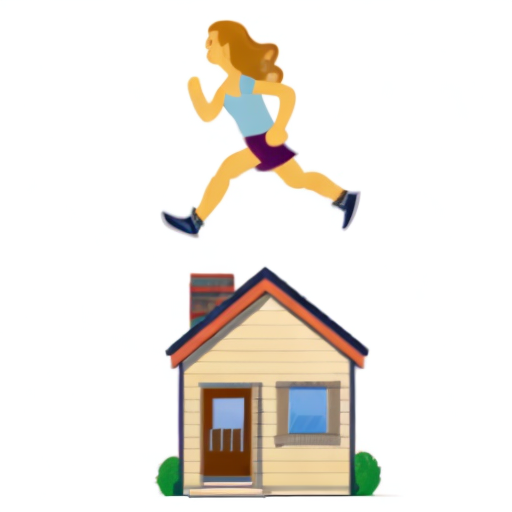

[None, None]

In [18]:
my_prompt = 'A detailed photo of a woman running on the roof of a house.'
uploaded_sd_images = sd_img2img_generate_gpu(my_prompt, [uploaded_img],
                                            strength=.5, guidance_scale=7.5,
                                            num_images=2, steps=100)

[display(image) for image in uploaded_sd_images]

## Appendix: Upscaling (Note: memory constrained)



Finally, we can try upscaling an image that we like. Because Stable Diffusion upscaling is very memory intensive, let's use a V100 to run it on. We also enable attention slicing to save some memory at the expense of throughput, and you can also try installing xformers and Triton to take advantage of memory-efficient attention.



In [ ]:
def sd_upscaler_generate(prompt, base_images, num_images=1,
                         steps=50, guidance_scale=7.5, attention_slicing='auto',
                         model_id="stabilityai/stable-diffusion-x4-upscaler"):
    import runhouse as rh
    from diffusers import StableDiffusionUpscalePipeline
    import torch

    pipe = rh.get_pinned_object(model_id + 'upscaler')
    if pipe is None:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cuda.matmul.allow_fp16_reduced_precision_reduction = True
        pipe = StableDiffusionUpscalePipeline.from_pretrained(model_id, torch_dtype=torch.float16).to('cuda')
        pipe.enable_attention_slicing(attention_slicing)
        # pipe.enable_xformers_memory_efficient_attention = True
        rh.pin_to_memory(model_id + 'upscaler', pipe)
    torch.no_grad()
    ret = []
    for image in base_images:
        ret = ret + pipe(prompt,
                         image=image,
                         num_images_per_prompt=num_images,
                         num_inference_steps=steps,
                         guidance_scale=guidance_scale).images
    return ret

v100_gpu = rh.cluster(name='rh-v100', instance_type='V100:1', provider='cheapest')
# If you change anything inside of the `if pipe is None` block, you'll need to clear the pins for your changes to take effect.
# v100_gpu.clear_pins()
sd_upscaler_generate_gpu = rh.send(fn=sd_upscaler_generate, hardware=v100_gpu,
                                    reqs=['local:./', 'torch --upgrade --extra-index-url https://download.pytorch.org/whl/cu116',
                                   'diffusers', 'transformers', 'accelerate'],
                                    name='sd_upscaler_generate').save()

INFO | 2023-02-07 21:17:24,581 | Running sd_upscaler_generate via gRPC
INFO | 2023-02-07 21:20:14,315 | Time to send message: 169.73 seconds


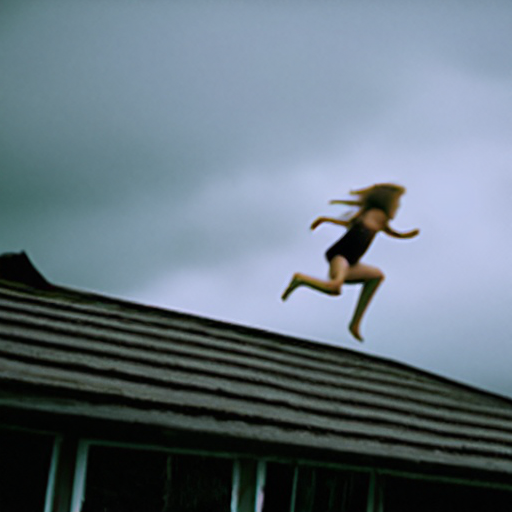

[None]

In [24]:
sd_upscaled_images = sd_upscaler_generate_gpu(rh_prompt,
                                              [rh_logo_dalle_images[0].resize((128, 128))],
                                              guidance_scale=7.5,
                                              attention_slicing='max',
                                              num_images=1, steps=50)

[display(image) for image in sd_upscaled_images]